In [33]:
# ==========================================
# DATA DOWNLOAD
# ==========================================
!pip install kagglehub
import kagglehub, os

# Download dataset from Kaggle
path = kagglehub.dataset_download("raghadalharbi/breast-cancer-gene-expression-profiles-metabric")


In [34]:
# Install all required packages 
!pip install lifelines scikit-survival pandas numpy matplotlib seaborn scikit-learn

In [35]:
# ==========================================
# 0. SETUP
# ==========================================

# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Survival analysis
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test, proportional_hazard_test

# Machine learning (for later)
from sklearn.model_selection import train_test_split

# Settings
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)

%matplotlib inline
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")

Pandas version: 2.1.4
NumPy version: 1.26.4


In [36]:
# ==========================================
# 1. DATA LOADING & INITIAL EXPLORATION
# ==========================================

# Load data
df = pd.read_csv(os.path.join(path, 'METABRIC_RNA_Mutation.csv')) 
print("="*60)
print("DATASET OVERVIEW")
print("="*60)
print(f"\nShape: {df.shape[0]} rows × {df.shape[1]} columns")
print(f"\nFirst 5 rows:")
display(df.head())


DATASET OVERVIEW

Shape: 1904 rows × 693 columns

First 5 rows:


,patient_id,age_at_diagnosis,type_of_breast_surgery,cancer_type,cancer_type_detailed,cellularity,chemotherapy,pam50_+_claudin-low_subtype,cohort,er_status_measured_by_ihc,er_status,neoplasm_histologic_grade,her2_status_measured_by_snp6,her2_status,tumor_other_histologic_subtype,hormone_therapy,inferred_menopausal_state,integrative_cluster,primary_tumor_laterality,lymph_nodes_examined_positive,mutation_count,nottingham_prognostic_index,oncotree_code,overall_survival_months,overall_survival,...,foxo1_mut,nt5e_mut,ccnd3_mut,nr3c1_mut,prkg1_mut,tbl1xr1_mut,frmd3_mut,smad2_mut,sgcd_mut,spaca1_mut,rasgef1b_mut,hist1h2bc_mut,nr2f1_mut,klrg1_mut,mbl2_mut,mtap_mut,ppp2cb_mut,smarcd1_mut,nras_mut,ndfip1_mut,hras_mut,prps2_mut,smarcb1_mut,stmn2_mut,siah1_mut
0,0,75.65,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,NaN,0,claudin-low,1.0,Positve,Positive,3.0,NEUTRAL,Negative,Ductal/NST,1,Post,4ER+,Right,10.0,NaN,6.044,IDC,140.500000,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,43.19,BREAST CONSERVING,Breast Cancer,Breast Invasive Ductal Carcinoma,High,0,LumA,1.0,Positve,Positive,3.0,NEUTRAL,Negative,Ductal/NST,1,Pre,4ER+,Right,0.0,2.0,4.020,IDC,84.633333,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,5,48.87,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,High,1,LumB,1.0,Positve,Positive,2.0,NEUTRAL,Negative,Ductal/NST,1,Pre,3,Right,1.0,2.0,4.030,IDC,163.700000,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,6,47.68,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,Moderate,1,LumB,1.0,Positve,Positive,2.0,NEUTRAL,Negative,Mixed,1,Pre,9,Right,3.0,1.0,4.050,MDLC,164.933333,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,8,76.97,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,High,1,LumB,1.0,Positve,Positive,3.0,NEUTRAL,Negative,Mixed,1,Post,9,Right,8.0,2.0,6.080,MDLC,41.366667,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [37]:
# Show all column names
cols = df.columns.tolist()
print(f"\nTotal columns: {len(cols)}\n")
for i in range(0, min(50, len(cols)), 5):  # Show first 50
    print(f"{i:3d}-{i+4:3d}: {', '.join(cols[i:i+5])}")

print("\n... (showing first 50 of 693 columns)")


Total columns: 693

  0-  4: patient_id, age_at_diagnosis, type_of_breast_surgery, cancer_type, cancer_type_detailed
  5-  9: cellularity, chemotherapy, pam50_+_claudin-low_subtype, cohort, er_status_measured_by_ihc
 10- 14: er_status, neoplasm_histologic_grade, her2_status_measured_by_snp6, her2_status, tumor_other_histologic_subtype
 15- 19: hormone_therapy, inferred_menopausal_state, integrative_cluster, primary_tumor_laterality, lymph_nodes_examined_positive
 20- 24: mutation_count, nottingham_prognostic_index, oncotree_code, overall_survival_months, overall_survival
 25- 29: pr_status, radio_therapy, 3-gene_classifier_subtype, tumor_size, tumor_stage
 30- 34: death_from_cancer, brca1, brca2, palb2, pten
 35- 39: tp53, atm, cdh1, chek2, nbn
 40- 44: nf1, stk11, bard1, mlh1, msh2
 45- 49: msh6, pms2, epcam, rad51c, rad51d

... (showing first 50 of 693 columns)


In [38]:
# Find survival columns
print("\n" + "="*60)
print("SURVIVAL-RELATED COLUMNS")
print("="*60)

survival_keywords = ['survival', 'time', 'status', 'event', 'death', 
                    'vital', 'os', 'follow', 'months', 'days']

survival_cols = [col for col in df.columns 
                if any(keyword in col.lower() for keyword in survival_keywords)]

for col in survival_cols:
    print(f"\n{col}:")
    print(f"  Type: {df[col].dtype}")
    print(f"  Missing: {df[col].isnull().sum()} ({df[col].isnull().mean()*100:.1f}%)")
    
    if df[col].dtype in ['int64', 'float64']:
        print(f"  Range: {df[col].min():.1f} to {df[col].max():.1f}")
        print(f"  Mean: {df[col].mean():.1f}")
    else:
        print(f"  Unique values: {df[col].unique()[:10]}")


SURVIVAL-RELATED COLUMNS

age_at_diagnosis:
  Type: float64
  Missing: 0 (0.0%)
  Range: 21.9 to 96.3
  Mean: 61.1

er_status_measured_by_ihc:
  Type: object
  Missing: 30 (1.6%)
  Unique values: ['Positve' 'Negative' nan]

er_status:
  Type: object
  Missing: 0 (0.0%)
  Unique values: ['Positive' 'Negative']

her2_status_measured_by_snp6:
  Type: object
  Missing: 0 (0.0%)
  Unique values: ['NEUTRAL' 'LOSS' 'GAIN' 'UNDEF']

her2_status:
  Type: object
  Missing: 0 (0.0%)
  Unique values: ['Negative' 'Positive']

lymph_nodes_examined_positive:
  Type: float64
  Missing: 0 (0.0%)
  Range: 0.0 to 45.0
  Mean: 2.0

nottingham_prognostic_index:
  Type: float64
  Missing: 0 (0.0%)
  Range: 1.0 to 6.4
  Mean: 4.0

overall_survival_months:
  Type: float64
  Missing: 0 (0.0%)
  Range: 0.0 to 355.2
  Mean: 125.1

overall_survival:
  Type: int64
  Missing: 0 (0.0%)
  Range: 0.0 to 1.0
  Mean: 0.4

pr_status:
  Type: object
  Missing: 0 (0.0%)
  Unique values: ['Negative' 'Positive']

death_from

In [39]:
# Search for clinical columns
print("\n" + "="*60)
print("CLINICAL COLUMNS")
print("="*60)

clinical_keywords = ['age', 'stage', 'grade', 'er', 'pr', 'her2', 
                    'tumor', 'receptor', 'type', 'subtype', 'patient']

clinical_cols = [col for col in df.columns 
                if any(keyword in col.lower() for keyword in clinical_keywords)]

print(f"Found {len(clinical_cols)} potential clinical variables:\n")
for col in clinical_cols[:15]:  # Show first 15
    print(f"{col}:")
    print(f"  Type: {df[col].dtype}")
    
    if df[col].dtype == 'object':
        print(f"  Values: {df[col].value_counts().head(5).to_dict()}")
    else:
        print(f"  Range: {df[col].min():.1f} to {df[col].max():.1f}")
    print()


CLINICAL COLUMNS
Found 65 potential clinical variables:

patient_id:
  Type: int64
  Range: 0.0 to 7299.0

age_at_diagnosis:
  Type: float64
  Range: 21.9 to 96.3

type_of_breast_surgery:
  Type: object
  Values: {'MASTECTOMY': 1127, 'BREAST CONSERVING': 755}

cancer_type:
  Type: object
  Values: {'Breast Cancer': 1903, 'Breast Sarcoma': 1}

cancer_type_detailed:
  Type: object
  Values: {'Breast Invasive Ductal Carcinoma': 1500, 'Breast Mixed Ductal and Lobular Carcinoma': 207, 'Breast Invasive Lobular Carcinoma': 142, 'Breast Invasive Mixed Mucinous Carcinoma': 22, 'Breast': 17}

chemotherapy:
  Type: int64
  Range: 0.0 to 1.0

pam50_+_claudin-low_subtype:
  Type: object
  Values: {'LumA': 679, 'LumB': 461, 'Her2': 220, 'claudin-low': 199, 'Basal': 199}

er_status_measured_by_ihc:
  Type: object
  Values: {'Positve': 1445, 'Negative': 429}

er_status:
  Type: object
  Values: {'Positive': 1459, 'Negative': 445}

neoplasm_histologic_grade:
  Type: float64
  Range: 1.0 to 3.0

her2_s

In [40]:
# Count gene expression columns
print("\n" + "="*60)
print("GENE EXPRESSION COLUMNS")
print("="*60)

# Identify non-genetic covariates and exclude
exclude_keywords = ['patient', 'age', 'stage', 'grade', 'er', 'pr', 'her2',
                   'survival', 'status', 'type', 'cohort', 'tumor', 'death']

potential_genes = [col for col in df.columns 
                  if not any(keyword in col.lower() for keyword in exclude_keywords)]

print(f"Potential gene expression columns: {len(potential_genes)}")
print(f"\nFirst 20 examples:")
for i, gene in enumerate(potential_genes[:20]):
    print(f"  {gene}")


GENE EXPRESSION COLUMNS
Potential gene expression columns: 627

First 20 examples:
  cellularity
  lymph_nodes_examined_positive
  mutation_count
  oncotree_code
  brca1
  brca2
  palb2
  pten
  tp53
  atm
  cdh1
  chek2
  nbn
  nf1
  stk11
  bard1
  mlh1
  msh2
  msh6
  pms2


In [41]:
# ==========================================
# 2. DATA PREPARATION
# ==========================================

print("="*60)
print("DATA CLEANING & VARIABLE SELECTION")
print("="*60)

# Create working dataset
df_clean = df.copy()

# Standardize survival variables
df_clean['time'] = df_clean['overall_survival_months']
df_clean['event'] = df_clean['overall_survival']  # Already 0/1

# Basic quality checks
print(f"\nOriginal dataset: {len(df)} patients")
print(f"Survival time range: {df_clean['time'].min():.1f} to {df_clean['time'].max():.1f} months")
print(f"Events: {df_clean['event'].sum()} ({df_clean['event'].mean():.1%})")
print(f"Censored: {(1-df_clean['event']).sum()} ({(1-df_clean['event']).mean():.1%})")

DATA CLEANING & VARIABLE SELECTION

Original dataset: 1904 patients
Survival time range: 0.0 to 355.2 months
Events: 801 (42.1%)
Censored: 1103 (57.9%)


In [42]:
# Apply inclusion/exclusion criteria
print("\n" + "="*60)
print("APPLYING INCLUSION/EXCLUSION CRITERIA")
print("="*60)

# Remove patients with invalid survival data
n_before = len(df_clean)

# Remove zero or negative survival times
df_clean = df_clean[df_clean['time'] > 0]
print(f"Removed {n_before - len(df_clean)} patients with time ≤ 0")

# Remove missing survival data (shouldn't be any, but check)
n_before = len(df_clean)
df_clean = df_clean[df_clean['time'].notna() & df_clean['event'].notna()]
print(f"Removed {n_before - len(df_clean)} patients with missing survival data")

print(f"\n Final analytic cohort: {len(df_clean)} patients")
print(f"  Events: {df_clean['event'].sum()} ({df_clean['event'].mean():.1%})")
print(f"  Median follow-up: {df_clean['time'].median():.1f} months")


APPLYING INCLUSION/EXCLUSION CRITERIA
Removed 1 patients with time ≤ 0
Removed 0 patients with missing survival data

 Final analytic cohort: 1903 patients
  Events: 800 (42.0%)
  Median follow-up: 115.6 months


In [43]:
# Define clinical variables
print("\n" + "="*60)
print("CLINICAL VARIABLES")
print("="*60)

clinical_cols = [
    'age_at_diagnosis',
    'er_status',
    'pr_status', 
    'her2_status',
    'neoplasm_histologic_grade',
    'lymph_nodes_examined_positive',
    'tumor_size',
    #'tumor_stage', ## dropping due to high missingness
    'chemotherapy',
    'radio_therapy',
    'hormone_therapy',
    'pam50_+_claudin-low_subtype'
]


print(f"Selected {len(clinical_cols)} clinical variables:")
for col in clinical_cols:
    missing = df_clean[col].isnull().sum()
    missing_pct = missing / len(df_clean) * 100
    print(f"  {col}: {missing} missing ({missing_pct:.1f}%)")
    
    if df_clean[col].dtype == 'object':
        print(f"    Distribution: {df_clean[col].value_counts().to_dict()}")
    else:
        print(f"    Mean ± SD: {df_clean[col].mean():.1f} ± {df_clean[col].std():.1f}")


CLINICAL VARIABLES
Selected 11 clinical variables:
  age_at_diagnosis: 0 missing (0.0%)
    Mean ± SD: 61.1 ± 13.0
  er_status: 0 missing (0.0%)
    Distribution: {'Positive': 1459, 'Negative': 444}
  pr_status: 0 missing (0.0%)
    Distribution: {'Positive': 1009, 'Negative': 894}
  her2_status: 0 missing (0.0%)
    Distribution: {'Negative': 1667, 'Positive': 236}
  neoplasm_histologic_grade: 71 missing (3.7%)
    Mean ± SD: 2.4 ± 0.7
  lymph_nodes_examined_positive: 0 missing (0.0%)
    Mean ± SD: 2.0 ± 4.1
  tumor_size: 19 missing (1.0%)
    Mean ± SD: 26.2 ± 15.2
  chemotherapy: 0 missing (0.0%)
    Mean ± SD: 0.2 ± 0.4
  radio_therapy: 0 missing (0.0%)
    Mean ± SD: 0.6 ± 0.5
  hormone_therapy: 0 missing (0.0%)
    Mean ± SD: 0.6 ± 0.5
  pam50_+_claudin-low_subtype: 0 missing (0.0%)
    Distribution: {'LumA': 679, 'LumB': 461, 'Her2': 220, 'Basal': 199, 'claudin-low': 198, 'Normal': 140, 'NC': 6}


In [44]:
# Define gene expression variables
print("\n" + "="*60)
print("GENE EXPRESSION VARIABLES")
print("="*60)

# Identify gene columns (exclude clinical/administrative variables)
exclude_cols = ['patient_id', 'age_at_diagnosis', 'type_of_breast_surgery',
                'cancer_type', 'cancer_type_detailed', 'cellularity',
                'chemotherapy', 'pam50_+_claudin-low_subtype',
                'cohort', 'er_status_measured_by_ihc', 'er_status',
                'neoplasm_histologic_grade', 'her2_status_measured_by_snp6',
                'her2_status', 'tumor_other_histologic_subtype',
                'hormone_therapy', 'inferred_menopausal_state',
                'integrative_cluster', 'lymph_nodes_examined_positive',
                'mutation_count', 'nottingham_prognostic_index',
                'oncotree_code', 'overall_survival_months', 'overall_survival',
                'pr_status', 'primary_tumor_laterality', 'radio_therapy',
                'tumor_size', 'tumor_stage', 'death_from_cancer',
                'time', 'event']

# Gene columns are everything else
gene_cols = [col for col in df_clean.columns if col not in exclude_cols]

print(f"Identified {len(gene_cols)} gene expression features")
print(f"\nFirst 20 genes: {gene_cols[:20]}")
print(f"Last 20 genes: {gene_cols[-20:]}")

# Check for missing data in genes
gene_missing = df_clean[gene_cols].isnull().sum()
genes_with_missing = gene_missing[gene_missing > 0]

if len(genes_with_missing) > 0:
    print(f"\n{len(genes_with_missing)} genes have missing data:")
    print(genes_with_missing.head(10))
else:
    print("\n No missing data in gene expression features")


GENE EXPRESSION VARIABLES
Identified 663 gene expression features

First 20 genes: ['3-gene_classifier_subtype', 'brca1', 'brca2', 'palb2', 'pten', 'tp53', 'atm', 'cdh1', 'chek2', 'nbn', 'nf1', 'stk11', 'bard1', 'mlh1', 'msh2', 'msh6', 'pms2', 'epcam', 'rad51c', 'rad51d']
Last 20 genes: ['tbl1xr1_mut', 'frmd3_mut', 'smad2_mut', 'sgcd_mut', 'spaca1_mut', 'rasgef1b_mut', 'hist1h2bc_mut', 'nr2f1_mut', 'klrg1_mut', 'mbl2_mut', 'mtap_mut', 'ppp2cb_mut', 'smarcd1_mut', 'nras_mut', 'ndfip1_mut', 'hras_mut', 'prps2_mut', 'smarcb1_mut', 'stmn2_mut', 'siah1_mut']

1 genes have missing data:
3-gene_classifier_subtype    204
dtype: int64


In [45]:
# Handle missing data
print("\n" + "="*60)
print("MISSING DATA HANDLING")
print("="*60)

# For genes: median imputation if < 10% missing
if len(genes_with_missing) > 0:
    print("Imputing gene expression missing values with median...")
    for gene in genes_with_missing.index:
        missing_pct = genes_with_missing[gene] / len(df_clean)
        if missing_pct < 0.10:
            df_clean[gene].fillna(df_clean[gene].median(), inplace=True)
        else:
            print(f"  Warning: {gene} has {missing_pct:.1%} missing - consider excluding")

# For clinical variables: will handle in Cox model (complete case)
clinical_missing = df_clean[clinical_cols].isnull().sum()
print(f"\nClinical variables missing data:")
print(clinical_missing[clinical_missing > 0])


MISSING DATA HANDLING
Imputing gene expression missing values with median...

Clinical variables missing data:
neoplasm_histologic_grade    71
tumor_size                   19
dtype: int64


In [46]:
# ==========================================
# MISSING DATA DECISIONS
# ==========================================

print("\n" + "="*60)
print("MISSING DATA DECISIONS")
print("="*60)

# Decision 1: Exclude gene with >10% missing
gene_to_exclude = '3-gene_classifier_subtype'
if gene_to_exclude in gene_cols:
    gene_cols.remove(gene_to_exclude)
    print(f" Excluded {gene_to_exclude} (10.7% missing)")

print(f"Final gene count: {len(gene_cols)} genes")

# Decision 2: Tumor grade missing
grade_missing = df_clean['neoplasm_histologic_grade'].isnull().sum()
grade_missing_pct = grade_missing / len(df_clean) * 100

print(f"\nTumor grade missing: {grade_missing} ({grade_missing_pct:.1f}%)")
print("Decision: Use complete case analysis for Cox models")
print("(Patients with missing grade will be excluded from clinical model)")

# Check how many patients we'll lose
cox_complete = df_clean[clinical_cols + ['time', 'event']].dropna()
print(f"\nPatients with complete clinical data: {len(cox_complete)} / {len(df_clean)}")
print(f"Lost to missing: {len(df_clean) - len(cox_complete)} ({(len(df_clean) - len(cox_complete))/len(df_clean)*100:.1f}%)")


MISSING DATA DECISIONS
 Excluded 3-gene_classifier_subtype (10.7% missing)
Final gene count: 662 genes

Tumor grade missing: 71 (3.7%)
Decision: Use complete case analysis for Cox models
(Patients with missing grade will be excluded from clinical model)

Patients with complete clinical data: 1815 / 1903
Lost to missing: 88 (4.6%)


In [47]:
# Summary of final dataset
print("\n" + "="*60)
print("FINAL ANALYTIC DATASET SUMMARY")
print("="*60)

print(f"Total patients: {len(cox_complete)}")
print(f"Events (deaths): {cox_complete['event'].sum()}")
print(f"Censored: {(1-cox_complete['event']).sum()}")
print(f"Follow-up time: {cox_complete['time'].median():.1f} months (median)")
print(f"\nFeature counts:")
print(f"  Clinical variables: {len(clinical_cols)}")
print(f"  Gene expression: {len(gene_cols)}")
print(f"  Total features: {len(clinical_cols) + len(gene_cols)}")

# Save the cleaned dataset info
print(f"\n Data preparation complete")


FINAL ANALYTIC DATASET SUMMARY
Total patients: 1815
Events (deaths): 774
Censored: 1041
Follow-up time: 114.6 months (median)

Feature counts:
  Clinical variables: 11
  Gene expression: 662
  Total features: 673

 Data preparation complete


In [48]:
# ==========================================
# 3. KAPLAN-MEIER SURVIVAL ANALYSIS
# ==========================================

from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

print("="*60)
print("KAPLAN-MEIER SURVIVAL CURVES")
print("="*60)

KAPLAN-MEIER SURVIVAL CURVES


In [49]:

os.makedirs('figures', exist_ok=True)


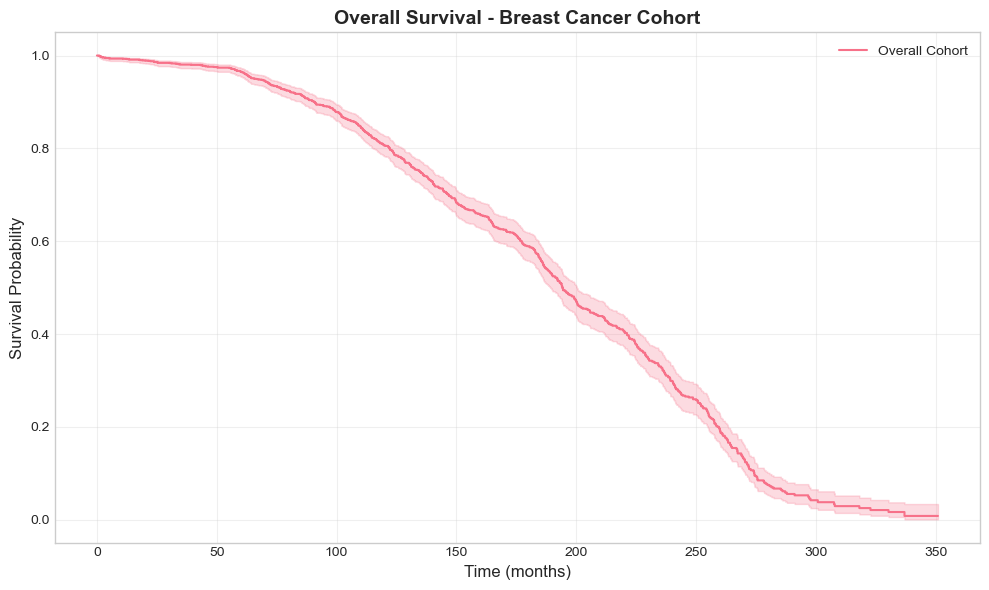


=== Overall Survival Statistics ===
Median survival: 194.3 months
5-year survival probability: 96.54%
95% CI for 5-year survival: [95.44%, 97.27%]


In [50]:
# Fit overall KM curve
kmf = KaplanMeierFitter()
kmf.fit(durations=cox_complete['time'], 
        event_observed=cox_complete['event'],
        label='Overall Cohort')

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
kmf.plot_survival_function(ax=ax, ci_show=True)
plt.title('Overall Survival - Breast Cancer Cohort', fontsize=14, fontweight='bold')
plt.xlabel('Time (months)', fontsize=12)
plt.ylabel('Survival Probability', fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('figures/km_overall.png', dpi=300, bbox_inches='tight')
plt.show()

# Summary statistics
median_survival = kmf.median_survival_time_
survival_5yr = kmf.predict(60) 

print(f"\n=== Overall Survival Statistics ===")
print(f"Median survival: {median_survival:.1f} months")
print(f"5-year survival probability: {survival_5yr:.2%}")
print(f"95% CI for 5-year survival: [{kmf.confidence_interval_survival_function_.iloc[kmf.timeline.searchsorted(60), 0]:.2%}, "
      f"{kmf.confidence_interval_survival_function_.iloc[kmf.timeline.searchsorted(60), 1]:.2%}]")


SURVIVAL BY ER STATUS


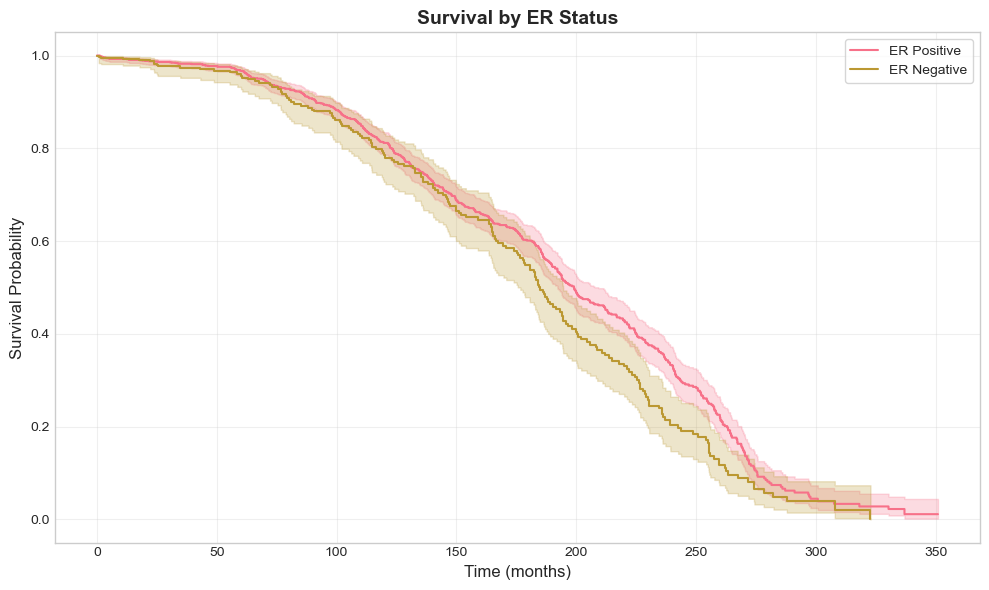


ER Positive (n=1384): Median survival = 149.9 months
ER Negative (n=431): Median survival = 169.7 months

Log-rank test:
  Test statistic: 7.10
  P-value: 0.0077
  Significant difference in survival by ER status


In [51]:
# Stratified KM curve by ER status
print("\n" + "="*60)
print("SURVIVAL BY ER STATUS")
print("="*60)

fig, ax = plt.subplots(figsize=(10, 6))

# ER positive
er_pos = cox_complete[cox_complete['er_status'] == 'Positive']
kmf.fit(durations=er_pos['time'], 
        event_observed=er_pos['event'],
        label='ER Positive')
kmf.plot_survival_function(ax=ax, ci_show=True)

# ER negative
er_neg = cox_complete[cox_complete['er_status'] == 'Negative']
kmf.fit(durations=er_neg['time'], 
        event_observed=er_neg['event'],
        label='ER Negative')
kmf.plot_survival_function(ax=ax, ci_show=True)

plt.title('Survival by ER Status', fontsize=14, fontweight='bold')
plt.xlabel('Time (months)', fontsize=12)
plt.ylabel('Survival Probability', fontsize=12)
plt.grid(alpha=0.3)
plt.legend(loc='best', frameon=True)
plt.tight_layout()
plt.savefig('figures/km_by_er_status.png', dpi=300, bbox_inches='tight')
plt.show()

# Log-rank test
results = logrank_test(
    durations_A=er_pos['time'],
    durations_B=er_neg['time'],
    event_observed_A=er_pos['event'],
    event_observed_B=er_neg['event']
)

print(f"\nER Positive (n={len(er_pos)}): Median survival = {er_pos['time'][er_pos['event']==1].median():.1f} months")
print(f"ER Negative (n={len(er_neg)}): Median survival = {er_neg['time'][er_neg['event']==1].median():.1f} months")
print(f"\nLog-rank test:")
print(f"  Test statistic: {results.test_statistic:.2f}")
print(f"  P-value: {results.p_value:.4f}")

if results.p_value < 0.05:
    print(f"  Significant difference in survival by ER status")
else:
    print(f"  No significant difference in survival by ER status")


SURVIVAL BY HER2 STATUS


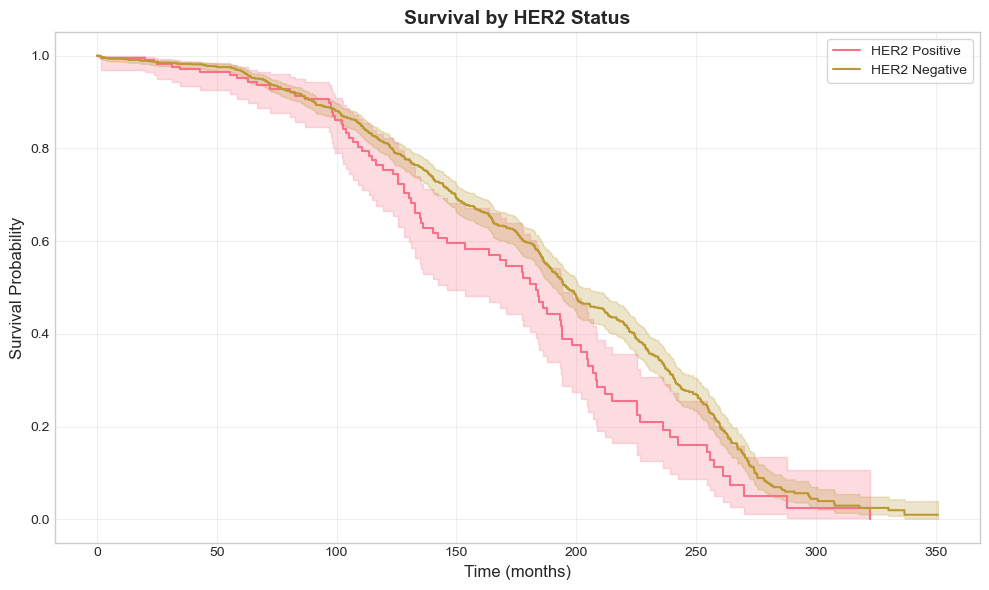


HER2 Positive (n=227): Median survival = 136.2 months
HER2 Negative (n=1588): Median survival = 157.7 months

Log-rank test p-value: 0.0076
   Significant difference in survival by HER2 status


In [52]:
# Stratified KM curve by HER2 status
print("\n" + "="*60)
print("SURVIVAL BY HER2 STATUS")
print("="*60)

fig, ax = plt.subplots(figsize=(10, 6))

# HER2 positive
her2_pos = cox_complete[cox_complete['her2_status'] == 'Positive']
kmf.fit(durations=her2_pos['time'], 
        event_observed=her2_pos['event'],
        label='HER2 Positive')
kmf.plot_survival_function(ax=ax, ci_show=True)

# HER2 negative
her2_neg = cox_complete[cox_complete['her2_status'] == 'Negative']
kmf.fit(durations=her2_neg['time'], 
        event_observed=her2_neg['event'],
        label='HER2 Negative')
kmf.plot_survival_function(ax=ax, ci_show=True)

plt.title('Survival by HER2 Status', fontsize=14, fontweight='bold')
plt.xlabel('Time (months)', fontsize=12)
plt.ylabel('Survival Probability', fontsize=12)
plt.grid(alpha=0.3)
plt.legend(loc='best', frameon=True)
plt.tight_layout()
plt.savefig('figures/km_by_her2_status.png', dpi=300, bbox_inches='tight')
plt.show()

# Log-rank test
results_her2 = logrank_test(
    durations_A=her2_pos['time'],
    durations_B=her2_neg['time'],
    event_observed_A=her2_pos['event'],
    event_observed_B=her2_neg['event']
)

print(f"\nHER2 Positive (n={len(her2_pos)}): Median survival = {her2_pos['time'][her2_pos['event']==1].median():.1f} months")
print(f"HER2 Negative (n={len(her2_neg)}): Median survival = {her2_neg['time'][her2_neg['event']==1].median():.1f} months")
print(f"\nLog-rank test p-value: {results_her2.p_value:.4f}")
if results_her2.p_value < 0.05:
    print(f"   Significant difference in survival by HER2 status")
else:
    print(f"  No significant difference in survival by HER2 status")


SURVIVAL BY TUMOR GRADE


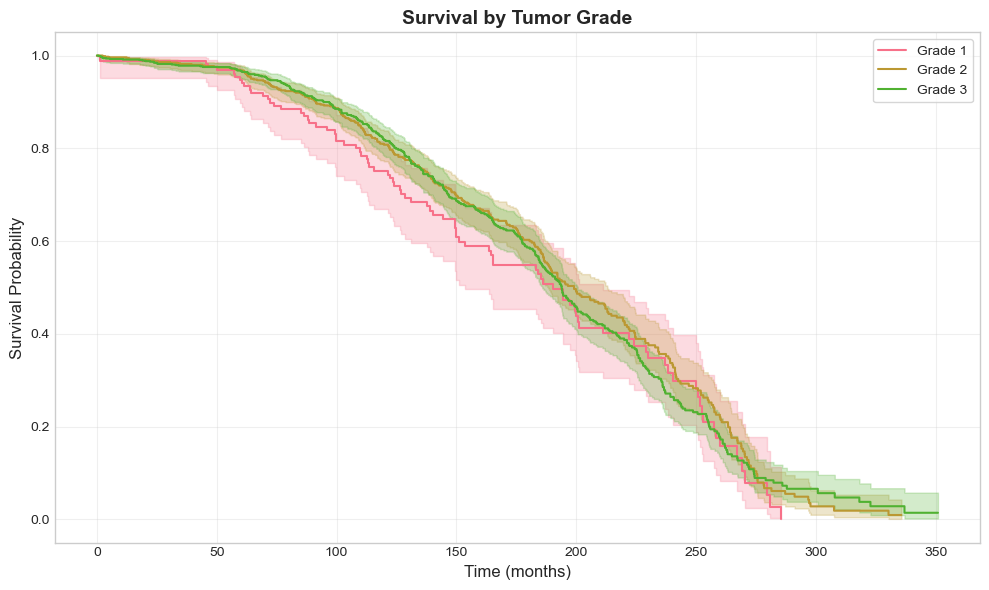


Sample sizes by grade:
neoplasm_histologic_grade
1.0    163
2.0    732
3.0    920
Name: count, dtype: int64
Grade 1 (n=163): Median survival = 190.2 months
Grade 2 (n=732): Median survival = 199.1 months
Grade 3 (n=920): Median survival = 194.0 months


In [69]:
# Stratified KM curve by tumor grade
print("\n" + "="*60)
print("SURVIVAL BY TUMOR GRADE")
print("="*60)

fig, ax = plt.subplots(figsize=(10, 6))


grades = sorted(cox_complete['neoplasm_histologic_grade'].unique())
median_survivals = {}

for grade in grades:
    grade_subset = cox_complete[cox_complete['neoplasm_histologic_grade'] == grade]
    kmf.fit(durations=grade_subset['time'], 
            event_observed=grade_subset['event'],
            label=f'Grade {int(grade)}')
    kmf.plot_survival_function(ax=ax, ci_show=True) 
    median_survivals[int(grade)] = kmf.median_survival_time_


plt.title('Survival by Tumor Grade', fontsize=14, fontweight='bold')
plt.xlabel('Time (months)', fontsize=12)
plt.ylabel('Survival Probability', fontsize=12)
plt.grid(alpha=0.3)
plt.legend(loc='best', frameon=True)
plt.tight_layout()
plt.savefig('figures/km_by_grade.png', dpi=300, bbox_inches='tight')
plt.show()

# Sample sizes by grade
print("\nSample sizes by grade:")
print(cox_complete['neoplasm_histologic_grade'].value_counts().sort_index())
for grade in sorted(median_survivals.keys()):
    n = len(cox_complete[cox_complete['neoplasm_histologic_grade'] == grade])
    median = median_survivals[grade]
    print(f"Grade {grade} (n={n}): Median survival = {median:.1f} months")

In [54]:
# ==========================================
# 4. COX PROPORTIONAL HAZARDS REGRESSION
# ==========================================

from lifelines import CoxPHFitter
from lifelines.statistics import proportional_hazard_test
from sklearn.model_selection import train_test_split

print("="*60)
print("COX REGRESSION - CLINICAL VARIABLES")
print("="*60)

COX REGRESSION - CLINICAL VARIABLES


In [55]:
# Select variables for Cox model
cox_vars = clinical_cols + ['time', 'event']

# Create modeling dataset
cox_df = cox_complete[cox_vars].copy()

# Encode categorical variables
cox_df = pd.get_dummies(cox_df, 
                        columns=['er_status', 'pr_status', 'her2_status', 'pam50_+_claudin-low_subtype'],
                        drop_first=True)

# Display encoded variables
print(f"\nFinal Cox modeling dataset")
print(f"Shape: {cox_df.shape}")
print(f"Variables: {[col for col in cox_df.columns if col not in ['time', 'event']]}")

# Check for any remaining missing values
print(f"\nMissing values check:")
print(cox_df.isnull().sum()[cox_df.isnull().sum() > 0])


Final Cox modeling dataset
Shape: (1815, 18)
Variables: ['age_at_diagnosis', 'neoplasm_histologic_grade', 'lymph_nodes_examined_positive', 'tumor_size', 'chemotherapy', 'radio_therapy', 'hormone_therapy', 'er_status_Positive', 'pr_status_Positive', 'her2_status_Positive', 'pam50_+_claudin-low_subtype_Her2', 'pam50_+_claudin-low_subtype_LumA', 'pam50_+_claudin-low_subtype_LumB', 'pam50_+_claudin-low_subtype_NC', 'pam50_+_claudin-low_subtype_Normal', 'pam50_+_claudin-low_subtype_claudin-low']

Missing values check:
Series([], dtype: int64)


In [56]:
# Fit Cox proportional hazards model
print("\n" + "="*60)
print("FITTING COX MODEL")
print("="*60)

cph = CoxPHFitter()
cph.fit(cox_df, duration_col='time', event_col='event')

# Display results
print("\n" + cph.summary.to_string())

# Model performance
print(f"\n{'='*60}")
print(f"MODEL PERFORMANCE")
print(f"{'='*60}")
print(f"Concordance Index (C-index): {cph.concordance_index_:.3f}")
print(f"Log-likelihood: {cph.log_likelihood_:.2f}")
print(f"AIC: {cph.AIC_partial_:.2f}")


FITTING COX MODEL

                                             coef  exp(coef)  se(coef)  coef lower 95%  coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%  cmp to         z             p   -log2(p)
covariate                                                                                                                                                                                  
age_at_diagnosis                        -0.005533   0.994482  0.003611       -0.012611        0.001545             0.987468             1.001547     0.0 -1.532051  1.255097e-01   2.994129
neoplasm_histologic_grade               -0.228124   0.796026  0.063102       -0.351801       -0.104446             0.703420             0.900823     0.0 -3.615171  3.001489e-04  11.702034
lymph_nodes_examined_positive           -0.024611   0.975690  0.016612       -0.057170        0.007949             0.944433             1.007981     0.0 -1.481458  1.384845e-01   2.852203
tumor_size                              

In [57]:
from sksurv.linear_model import CoxnetSurvivalAnalysis
from sklearn.preprocessing import StandardScaler
import numpy as np

print("\n" + "="*60)
print("PREPARING GENOMIC DATA")
print("="*60)

# Get gene expression columns
print(f"Total gene columns identified: {len(gene_cols)}")

# CRITICAL: Filter to only NUMERIC columns (gene expression values)
X_genes_all = df_clean.loc[cox_complete.index, gene_cols].copy()

# Identify numeric columns only
numeric_genes = []
non_numeric_genes = []

for col in gene_cols:
    if X_genes_all[col].dtype in ['float64', 'int64']:
        numeric_genes.append(col)
    else:
        non_numeric_genes.append(col)

print(f"\nNumeric gene columns: {len(numeric_genes)}")
print(f"Non-numeric columns (excluded): {len(non_numeric_genes)}")

if len(non_numeric_genes) > 0 and len(non_numeric_genes) <= 20:
    print(f"  Examples of excluded columns: {non_numeric_genes[:10]}")

# Use only numeric genes
X_genes = X_genes_all[numeric_genes].copy()

print(f"\nFinal gene expression dataset:")
print(f"  Samples: {len(X_genes)}")
print(f"  Features: {len(numeric_genes)} numeric genes")

# Handle any remaining missing values
missing_genes = X_genes.isnull().sum()
if missing_genes.sum() > 0:
    print(f"\nImputing {missing_genes.sum()} missing values with median...")
    X_genes = X_genes.fillna(X_genes.median())

# Standardize gene expression
scaler = StandardScaler()
X_genes_scaled = pd.DataFrame(
    scaler.fit_transform(X_genes),
    columns=numeric_genes,
    index=X_genes.index
)

print("Gene expression data prepared and standardized")

# Update gene_cols to only numeric genes
gene_cols = numeric_genes



PREPARING GENOMIC DATA
Total gene columns identified: 662

Numeric gene columns: 489
Non-numeric columns (excluded): 173

Final gene expression dataset:
  Samples: 1815
  Features: 489 numeric genes
Gene expression data prepared and standardized


In [58]:
# Create structured array for scikit-survival
y = np.array(
    [(bool(e), float(t)) for e, t in zip(cox_complete['event'], cox_complete['time'])],
    dtype=[('event', bool), ('time', float)]
)

print(f"\nSurvival outcome array:")
print(f"  Shape: {y.shape}")
print(f"  Events: {y['event'].sum()} ({y['event'].mean():.1%})")
print(f"  Median time: {np.median(y['time']):.1f} months")


Survival outcome array:
  Shape: (1815,)
  Events: 774 (42.6%)
  Median time: 114.6 months


In [59]:
print("\n" + "="*60)
print("FITTING COXNET WITH LASSO PENALTY")
print("="*60)

# Fit CoxNet (LASSO for feature selection)
coxnet = CoxnetSurvivalAnalysis(
    l1_ratio=1.0,           # 1.0 = pure LASSO
    alpha_min_ratio=0.01,   # Range of penalty strengths
    max_iter=100,
    n_alphas=100,
    verbose=True            # Show progress
)

coxnet.fit(X_genes_scaled, y)




FITTING COXNET WITH LASSO PENALTY


,n_alphas,100
,alphas,None
,alpha_min_ratio,0.01
,l1_ratio,1.0
,penalty_factor,None
,normalize,False
,copy_X,True
,tol,1e-07
,max_iter,100
,verbose,True
,fit_baseline_model,False


In [60]:
os.makedirs('results', exist_ok=True)

print("\n" + "="*60)
print("FEATURE SELECTION RESULTS")
print("="*60)

# CoxNet fits multiple alphas, need to pick the best one
# The coefficients are stored as (n_features, n_alphas)
print(f"Coefficient matrix shape: {coxnet.coef_.shape}")
print(f"Number of alphas tested: {len(coxnet.alphas_)}")

# Find the alpha with reasonable sparsity (not all zeros, not all features)
n_features_per_alpha = np.sum(coxnet.coef_ != 0, axis=0)

print(f"\nFeatures selected across alphas:")
print(f"  Max: {n_features_per_alpha.max()} features")
print(f"  Min: {n_features_per_alpha.min()} features")
print(f"  At smallest alpha: {n_features_per_alpha[-1]} features")

# Use the alpha that selects a reasonable number of features (e.g., 10-30)
# Strategy: Find alpha closest to selecting 20 features
target_features = 20
best_alpha_idx = np.argmin(np.abs(n_features_per_alpha - target_features))

print(f"\nUsing alpha index {best_alpha_idx} (alpha={coxnet.alphas_[best_alpha_idx]:.4f})")
print(f"  This selects {n_features_per_alpha[best_alpha_idx]} features")

# Get coefficients at this alpha
coefficients = pd.Series(coxnet.coef_[:, best_alpha_idx], index=gene_cols)

# Find non-zero coefficients (selected genes)
selected_genes = coefficients[coefficients != 0].sort_values()

print(f"\n{'='*60}")
print(f"LASSO selected {len(selected_genes)} genes out of {len(gene_cols)}")
print(f"Sparsity: {(1 - len(selected_genes)/len(gene_cols))*100:.1f}% of genes eliminated")

if len(selected_genes) > 0:
    print(f"\nTop 10 protective genes (lowest coefficients, HR < 1):")
    for gene, coef in selected_genes.head(10).items():
        hr = np.exp(coef)
        print(f"  {gene}: coef={coef:.4f}, HR={hr:.3f}")
    
    print(f"\nTop 10 risk genes (highest coefficients, HR > 1):")
    for gene, coef in selected_genes.tail(10).items():
        hr = np.exp(coef)
        print(f"  {gene}: coef={coef:.4f}, HR={hr:.3f}")
    
    # Save selected genes
    hr_genes = pd.DataFrame({
        'Gene': selected_genes.index,
        'Coefficient': selected_genes.values,
        'Hazard Ratio': np.exp(selected_genes.values)
    }).sort_values('Hazard Ratio')
    
    hr_genes.to_csv('results/lasso_selected_genes.csv', index=False)
    print("\n Selected genes saved to results/lasso_selected_genes.csv")
    
else:
    print("\n No genes selected; so will try less regularization")
    # Use last alpha (minimum regularization)
    best_alpha_idx = -1
    coefficients = pd.Series(coxnet.coef_[:, best_alpha_idx], index=gene_cols)
    selected_genes = coefficients[coefficients != 0].sort_values()
    print(f"With minimum regularization: {len(selected_genes)} genes selected")


FEATURE SELECTION RESULTS
Coefficient matrix shape: (489, 100)
Number of alphas tested: 100

Features selected across alphas:
  Max: 390 features
  Min: 0 features
  At smallest alpha: 390 features

Using alpha index 30 (alpha=0.0447)
  This selects 20 features

LASSO selected 20 genes out of 489
Sparsity: 95.9% of genes eliminated

Top 10 protective genes (lowest coefficients, HR < 1):
  tsc1: coef=-0.0542, HR=0.947
  tsc2: coef=-0.0536, HR=0.948
  kmt2c: coef=-0.0080, HR=0.992
  e2f1: coef=-0.0072, HR=0.993
  cdkn2c: coef=0.0026, HR=1.003
  mapk14: coef=0.0036, HR=1.004
  star: coef=0.0103, HR=1.010
  casp10: coef=0.0155, HR=1.016
  bmp6: coef=0.0166, HR=1.017
  rb1: coef=0.0170, HR=1.017

Top 10 risk genes (highest coefficients, HR > 1):
  smad2: coef=0.0254, HR=1.026
  adam17: coef=0.0332, HR=1.034
  jak1: coef=0.0403, HR=1.041
  psen1: coef=0.0430, HR=1.044
  arid1a: coef=0.0433, HR=1.044
  myc: coef=0.0560, HR=1.058
  cxcr1: coef=0.0614, HR=1.063
  pdpk1: coef=0.0812, HR=1.085
 

In [61]:
print("\n" + "="*60)
print("GENOMIC MODEL PERFORMANCE")
print("="*60)

from sksurv.metrics import concordance_index_censored

# Get risk predictions using the selected alpha
# Need to rebuild model with just selected genes for proper evaluation
if len(selected_genes) > 0:
    # Use only selected genes
    from sksurv.linear_model import CoxPHSurvivalAnalysis
    
    X_selected = X_genes_scaled[selected_genes.index]
    
    # Fit a simple Cox model (no regularization) on selected genes
    cox_selected = CoxPHSurvivalAnalysis()
    cox_selected.fit(X_selected, y)
    
    # Get predictions
    risk_scores = cox_selected.predict(X_selected)
    
    # Calculate C-index
    c_index_genes = concordance_index_censored(
        y['event'], 
        y['time'], 
        risk_scores
    )[0]
    
    print(f"Genomic model ({len(selected_genes)} selected genes):")
    print(f"  C-index: {c_index_genes:.3f}")
    print(f"  Clinical model C-index: {cph.concordance_index_:.3f}")
    print(f"  Improvement: +{c_index_genes - cph.concordance_index_:.3f}")
    print(f"  Relative improvement: {((c_index_genes - cph.concordance_index_) / cph.concordance_index_)*100:.1f}%")
    
else:
    print("No genes selected, cannot evaluate genomic model")
    c_index_genes = np.nan


GENOMIC MODEL PERFORMANCE
Genomic model (20 selected genes):
  C-index: 0.713
  Clinical model C-index: 0.625
  Improvement: +0.088
  Relative improvement: 14.0%


In [62]:
print("\n" + "="*60)
print("COMBINED MODEL: CLINICAL + GENOMIC")
print("="*60)

if len(selected_genes) > 0:
    # Clinical features
    clinical_features = [col for col in cox_df.columns if col not in ['time', 'event']]
    X_clinical = cox_df[clinical_features]
    
    # Selected genes
    X_genes_selected = X_genes_scaled[selected_genes.index]
    
    # Combine
    X_combined = pd.concat([X_clinical, X_genes_selected], axis=1)
    
    print(f"Combined dataset:")
    print(f"  Clinical features: {len(clinical_features)}")
    print(f"  Genomic features: {len(selected_genes)}")
    print(f"  Total features: {X_combined.shape[1]}")
    
    # Fit Cox on combined
    combined_df = X_combined.copy()
    combined_df['time'] = cox_complete['time'].values
    combined_df['event'] = cox_complete['event'].values
    
    cph_combined = CoxPHFitter()
    cph_combined.fit(combined_df, duration_col='time', event_col='event')
    
    print(f"\nCombined model C-index: {cph_combined.concordance_index_:.3f}")
    print(f"Improvement over clinical: {cph_combined.concordance_index_ - cph.concordance_index_:.3f}")
    
else:
    print("Cannot build combined model (no genes selected)")
    cph_combined = None


COMBINED MODEL: CLINICAL + GENOMIC
Combined dataset:
  Clinical features: 16
  Genomic features: 20
  Total features: 36

Combined model C-index: 0.722
Improvement over clinical: 0.097


In [63]:
print("\n" + "="*60)
print("FINAL MODEL COMPARISON")
print("="*60)

results_comparison = pd.DataFrame({
    'Model': [
        'Clinical Only',
        'Genomic Only (LASSO)',
        'Combined (Clinical + Genomic)'
    ],
    'N Features': [
        len([col for col in cox_df.columns if col not in ['time', 'event']]),
        len(selected_genes),
        len(clinical_features) + len(selected_genes) if len(selected_genes) > 0 else 0
    ],
    'C-index': [
        cph.concordance_index_,
        c_index_genes,
        cph_combined.concordance_index_ if cph_combined else np.nan
    ]
})

results_comparison['Improvement vs Clinical'] = (
    results_comparison['C-index'] - results_comparison.loc[0, 'C-index']
)

print(results_comparison.to_string(index=False))

# Save
results_comparison.to_csv('results/model_comparison_final.csv', index=False)



FINAL MODEL COMPARISON
                        Model  N Features  C-index  Improvement vs Clinical
                Clinical Only          16 0.624967                 0.000000
         Genomic Only (LASSO)          20 0.712647                 0.087680
Combined (Clinical + Genomic)          36 0.722003                 0.097036


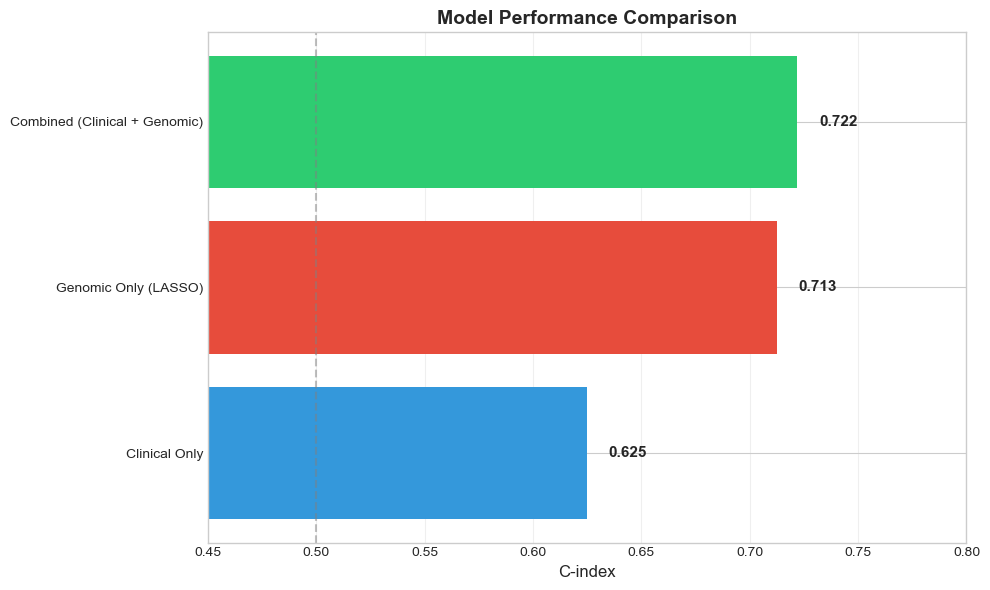

In [64]:
# Comparison plot
fig, ax = plt.subplots(figsize=(10, 6))
models = results_comparison['Model']
c_indices = results_comparison['C-index']

bars = ax.barh(models, c_indices, color=['#3498db', '#e74c3c', '#2ecc71'])
ax.axvline(x=0.5, color='gray', linestyle='--', alpha=0.5, label='Random (0.5)')
ax.set_xlabel('C-index', fontsize=12)
ax.set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
ax.set_xlim(0.45, 0.80)
ax.grid(alpha=0.3, axis='x')

for i, (model, c_idx) in enumerate(zip(models, c_indices)):
    if not np.isnan(c_idx):
        ax.text(c_idx + 0.01, i, f'{c_idx:.3f}', 
                va='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('figures/model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()